In [1]:
import sys         
sys.path.append('./../')        

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from src.data.load_data import load_ptbxl_data
from biosppy.signals import ecg, ppg

TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../data/sample")

In [3]:
data = pd.read_csv(DATASET_PATH / "mimic.csv")

In [53]:
from scipy.signal import savgol_filter, sosfilt, butter

class Signal:
    def __init__(self, name, data, fs):
        self.name = name
        self.data = data
        self.fs = fs
        self.n_samples = len(data)
        self.duration = self.n_samples / fs
        self.time = np.arange(1, self.n_samples+1) / fs
     
    def get_slice(self, start_time, end_time):
        mask = (self.time >= start_time) & (self.time <= end_time)
        new_name = self.name + f"_slice({start_time}-{end_time})"
        new_data = self.data[mask]
        return Signal(new_name, new_data, self.fs)
    
    def get_derivative(self, deriv=1, window_length=21, polyorder=5):
        new_name = self.name + f"_derivative({deriv})"
        new_data = savgol_filter(self.data, window_length, polyorder, deriv, delta = 1 / self.fs)
        return Signal(new_name, new_data, self.fs)
        
    def plot(self, start_time=0, width=10, first_der=False, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(18, 6))
        end_time = start_time + width
        signal_slice = self.get_slice(start_time, end_time)
        
        sig_plot = ax.plot(signal_slice.time, signal_slice.data, c=sns.color_palette()[0], lw=2, label=signal_slice.name)
        plots = [sig_plot[0]]
        if first_der:
            ax2 = ax.twinx()
            signal_slice_der = signal_slice.get_derivative()
            first_der_plot = ax2.plot(signal_slice_der.time, signal_slice_der.data, c=sns.color_palette()[1], lw=1, label=signal_slice_der.name)
            plots.append(first_der_plot[0])
            ax2.set_ylabel("First derivative values", fontsize=18)
            ax2.axhline(y = 0, c='black', ls='--', lw=0.5)
        labels = [plot.get_label() for plot in plots]
        ax.legend(plots, labels, loc=0)
        ax.set_ylabel("Signal values", fontsize=18)
        
    def extract_basic_features(self):
        self.basic_features = {
            "mean" : np.mean(self.data),
            "std" : np.std(self.data),
            "median": np.median(self.data),
        }
        return self.basic_features

In [54]:
ecg_signal = Signal('ecg', data['PLETH'].values, 125)

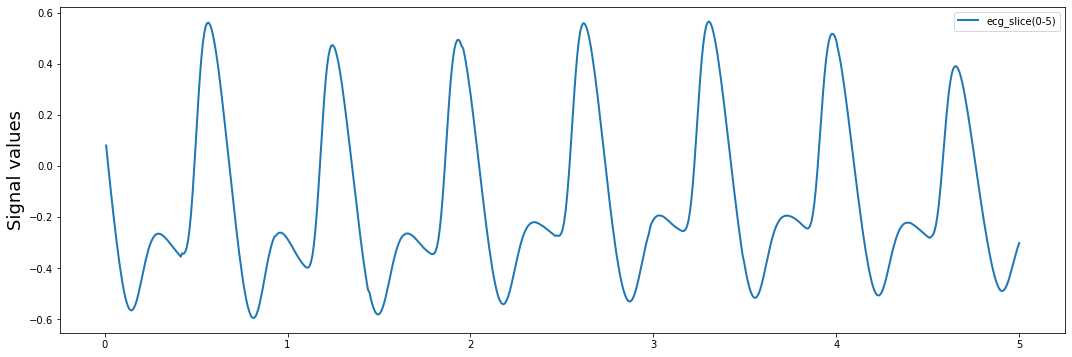

In [56]:
ecg_signal.plot(0, 5, first_der=False)